In [36]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingDeBerta import classify_node_isSentence, classify_node_isCatgory
from Stage2.classifyingEdges.rewritingOPENAI import add_context, summairse
from Stage2.classifyingEdges.classifyingOpenAI import classify_needsContext_openAI, classify_link_pairs_openAI, classify_pairwiseEdges_openAI
from Stage2.classifyingEdges.metrics import metrics
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

### Step 1. ###
Load the model and download the website

In [37]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
# htmlFile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://westinghousenuclear.com/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [38]:
# Get label edges from text nodes in the website
# sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/0000_test", remove_dupes=REMOVE_DUPES)
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

In [39]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, "%'\\s", lower=False), normalise_text(b, "%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

Extract unique nodes from the edges and create a mapping from node to edge

In [40]:
node_unique_label_index, node_to_edge_pos = np.unique(sorted_label_index, return_index=True)
node_to_edge_pos = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in node_to_edge_pos])
node_to_edge_x_pos, node_to_edge_y_pos = node_to_edge_pos[:,0], node_to_edge_pos[:,1]

node_unique_txts, node_unique_xpaths = txts[node_to_edge_x_pos,node_to_edge_y_pos], xpaths[node_to_edge_x_pos, node_to_edge_y_pos]

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [41]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isButton, buttonTxt = clean_instructional_text(txtsShortened, batch_size=32)
opmask = np.array(isButton, dtype=bool)
mask = np.logical_not(opmask)

isButtonNode = np.zeros_like(node_unique_txts, dtype=bool)
for key, value in buttonTxt.items():
    if value == 1:
        idx = np.where(node_unique_txts==key)
        isButtonNode[idx] = True

print("All the nodes filtered out:\n\n")
for key, value in buttonTxt.items():
    if value == 1:
        print(key)

All the nodes filtered out:


Take a Look
Learn more about how Westinghouse enhances training staffing and outsourcing with options that benefit your plants bottom line
Learn More
Explore Now
Learn More Watch Video
Join Our Team
Explore
Explore Careers
Read More
Access our custom technology library designed for nuclear engineering students and professionals
Explore our interactive 3D visualization tool for innovative answers to operating plant challenges
WestinghouseNavigator
Learn more about why Databricks selected Westinghouse AI for its 2025 Data Intelligence in Energy Utility Award


In [42]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

### Step 4. ###
This filters out all the low probability edges using the finding from the probability paper. At least one edge per node is saved

In [43]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

1332  ->  76


### Step 5. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [44]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=32)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
#print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


In [45]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [46]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [47]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [48]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following edges:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following edges:

 [['Westinghouse AP1000 Design Receives US Licensing Extension to 2046'
  'Westinghouse Expands Supply Chain with Six UK Companies']
 ['Westinghouse Expands Supply Chain with Six UK Companies'
  'Westinghouse AP1000 Design Receives US Licensing Extension to 2046']
 ['Fermi America Partners with Westinghouse to Support Licensing for Four AP1000 Units'
  'Westinghouse Expands Supply Chain with Six UK Companies']
 ['Shape Your Future' 'Manufacturing Operations Maintenance']
 ['Manufacturing Operations Maintenance' 'Shape Your Future']
 ['Shape Your Future' 'eVinci Microreactor']]


### 6. Finding each node that needs context to make a complete fact ###

    1) It uses DeBERTa-v3 model to split the nodes into more than a phrase and less that a phrase

For those that are <b> more than a phrase </b>

    2.1) GPT_4.1_mini decides if the sentences need more context

For those that are <b> less than a phrase </b>

    2.2) Use DeBERTa to categorise the value

The reason they are split is that it is a lot easier to create sentences from small "value to value" pairs. It is also good as the "value to sentence" edges are easier to extract information from if we know which are sentences (that need context) and which are values (that give context).

In [49]:
isSentence, isSentence_probs = classify_node_isSentence(node_unique_txts.tolist())
for isS, txt in zip(isSentence, node_unique_txts):
    print(isS, txt)

0 Shape Your Future
0 Explore Careers
1 Shaping Tomorrow's EnergyThrough Advanced Nuclear Technology
0 Product Spotlights
0 Join Our Team
0 AP1000 PWR
1 The world's first proven Generation III pressurized water reactor and passive safety plant available
0 Learn More
0 AP300 SMR
1 The AP300 SMR is the next evolution of the licensed AP1000 technology
0 Learn More Watch Video
0 eVinci Microreactor
1 The next generation small modular reactor for remote applications
0 Learn More Watch Video
0 News
0 Blog
0 WestinghouseIQ
1 Access our custom technology library designed for nuclear engineering students and professionals
0 Explore Now
0 WestinghouseNavigator
1 Explore our interactive 3D visualization tool for innovative answers to operating plant challenges
0 Take a Look
0 WestinghouseNuclearning
1 Enhance your training staffing and outsourcing needs with our training and resource solutions
0 Read More
0 Manufacturing Operations Maintenance
0 Explore
1 Westinghouse Expands Supply Chain with Si

In [50]:
isSentence = np.array(isSentence, dtype=bool)
node_sentences = node_unique_txts[isSentence]
if len(node_sentences) > 0:
    ####################################################################################################################Random to not waste money
    #sentenceNeedsContext = np.random.randint(2, size=node_sentences.shape)#
    sentenceNeedsContext = classify_needsContext_openAI(node_sentences, dry_run_confirm=True, batch_size=1)
    ####################################################################################################################
    sentenceNeedsContext=np.array(sentenceNeedsContext, dtype=bool)
    #Re padding and getting back to the dimension of node_unique_txts
    padded_sentenceNeedsContext = np.zeros(isSentence.shape, dtype=bool)
    padded_sentenceNeedsContext[isSentence] = sentenceNeedsContext
    print("Sentences that need context: ", node_unique_txts[padded_sentenceNeedsContext])


Expected total price: $0.0011372

Batch 0 ~input tokens=110, ~output tokens=2, est. cost=$0.0011 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 106  {input_tokens= 104  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 4.4800000000000005e-05  This batch cost: $ 4.4800000000000005e-05
output so far:  [NEWBATCH]0
results so far:  [0]

Batch 1 ~input tokens=118, ~output tokens=2, est. cost=$0.0011 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 112  {input_tokens= 110  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 9.200000000000001e-05  This batch cost: $ 4.720000000000001e-05
output so far:  [NEWBATCH]0[NEWBATCH]1
results so far:  [0, 1]

Batch 2 ~input tokens=117, ~output tokens=2, est. cost=$0.0011 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 113  {input_tokens= 111  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 0.00013960000000000003  This batch cost: $ 4.7600000000000005e-05
output so far:  [NEWBATCH]0[NEWBATCH]1[NEWBATCH]0
results so far:  [0, 1, 0]

Batch 3 

In [51]:
node_words = node_unique_txts[~isSentence]
node_words_isCatgory, (_, bestCategory) = classify_node_isCatgory(node_words.tolist())
for idx, (isC, word) in enumerate(zip(node_words_isCatgory, node_words)):
    if not isC:
        bestCategory[idx] = ""
        print("XX ", word, " XX")
    else:
        print(word, "\t\t->", bestCategory[idx])

padded_node_words_isCatgory = np.zeros(isSentence.shape, dtype=int)
padded_bestCategory =  np.full(isSentence.shape, "", dtype=object)
padded_node_words_isCatgory[~isSentence] = node_words_isCatgory
padded_bestCategory[~isSentence] = bestCategory
for idx, (isC, word) in enumerate(zip(padded_node_words_isCatgory, node_unique_txts)):
    if not isC:
        padded_bestCategory[idx] = ""

XX  Shape Your Future  XX
Explore Careers 		-> is only the name of a category
XX  Product Spotlights  XX
XX  Join Our Team  XX
AP1000 PWR 		-> is a number or amount
XX  Learn More  XX
AP300 SMR 		-> is a number or amount
XX  Learn More Watch Video  XX
eVinci Microreactor 		-> is a person, place, or thing
XX  Learn More Watch Video  XX
News 		-> is only the name of a category
XX  Blog  XX
XX  WestinghouseIQ  XX
XX  Explore Now  XX
WestinghouseNavigator 		-> is a person, place, or thing
Take a Look 		-> is a short modifier or add-on phrase that attaches to something else
XX  WestinghouseNuclearning  XX
XX  Read More  XX
XX  Manufacturing Operations Maintenance  XX
XX  Explore  XX
XX  Explore  XX
XX  Explore  XX
XX  Explore  XX
XX  Explore  XX
XX  Learn More  XX
XX  CarbonFree Energy  XX
XX  Learn More  XX
XX  Learn More  XX
Safety Getting The Facts Right 		-> is a comparison phrase
XX  Learn More  XX
Corporate 		-> is a person, place, or thing
XX  Explore  XX
XX  Engineering  XX
XX  Expl

### 7a. Focus on Sentences that need Context ###
This decides which sentences to send off for context addition.

Current Sentence filters:
1) isButton
2) isSentence that needs context

<i>(note snall fact nodes will be dealt with through a different pipeline. They go through a different process)</i>

In [52]:
padded_sentenceNeedsContext = np.array(((~isButtonNode) & padded_sentenceNeedsContext), dtype=bool)
node_label_NeedsContext = node_unique_label_index[padded_sentenceNeedsContext]
mask = np.isin(sorted_label_index[:,0], node_label_NeedsContext)
needsContext_text_edges = txts[mask]

print("Sentences being checked:")
for idx, isC in enumerate(padded_sentenceNeedsContext):
    if isC:
        print(node_unique_txts[idx])

Sentences being checked:
The world's first proven Generation III pressurized water reactor and passive safety plant available
The next generation small modular reactor for remote applications
For the only SMR based on advanced reactor technology thats already licensed and operating AP300 is the proven choice


In [53]:
# Compute all pairwise-edges
# Creating an array of [SENTENCE, CTX1, CTX2] to compare them

outputs_by_input = {}
for inp, out in needsContext_text_edges:
    outputs_by_input.setdefault(inp, []).append(out)

needsContext_allPairwise_text = []
for inp, outs in outputs_by_input.items():
    if len(outs) < 2:
        continue  # need at least two outputs to form a pair

    pair_iter = combinations(outs, 2)
    for c1, c2 in pair_iter:
        needsContext_allPairwise_text.append([inp, c1, c2])
needsContext_allPairwise_text = np.array(needsContext_allPairwise_text)
print(len(needsContext_allPairwise_text))
print(needsContext_text_edges)

7
[['The next generation small modular reactor for remote applications'
  'eVinci Microreactor']
 ["The world's first proven Generation III pressurized water reactor and passive safety plant available"
  'AP1000 PWR']
 ['The next generation small modular reactor for remote applications'
  'AP1000 PWR']
 ["The world's first proven Generation III pressurized water reactor and passive safety plant available"
  'eVinci Microreactor']
 ["The world's first proven Generation III pressurized water reactor and passive safety plant available"
  'AP300 SMR']
 ['For the only SMR based on advanced reactor technology thats already licensed and operating AP300 is the proven choice'
  'The established design of the AP1000 reactor offers unequaled safety economic competitiveness and improved more efficient operations']
 ['For the only SMR based on advanced reactor technology thats already licensed and operating AP300 is the proven choice'
  'WestinghouseNuclearning']
 ['For the only SMR based on advanc

In [54]:
print(needsContext_text_edges)

[['The next generation small modular reactor for remote applications'
  'eVinci Microreactor']
 ["The world's first proven Generation III pressurized water reactor and passive safety plant available"
  'AP1000 PWR']
 ['The next generation small modular reactor for remote applications'
  'AP1000 PWR']
 ["The world's first proven Generation III pressurized water reactor and passive safety plant available"
  'eVinci Microreactor']
 ["The world's first proven Generation III pressurized water reactor and passive safety plant available"
  'AP300 SMR']
 ['For the only SMR based on advanced reactor technology thats already licensed and operating AP300 is the proven choice'
  'The established design of the AP1000 reactor offers unequaled safety economic competitiveness and improved more efficient operations']
 ['For the only SMR based on advanced reactor technology thats already licensed and operating AP300 is the proven choice'
  'WestinghouseNuclearning']
 ['For the only SMR based on advanced

In [55]:
BATCH_SIZE = 4
# expects: needsContext_allPairwise_text = [[INPUT, OUT1, OUT2], ...]

# Work on a mutable copy; keep as generic objects (strings/ints/etc.)
remaining = [list(t) for t in needsContext_allPairwise_text]
removedEdges = []

def _choose_smaller(inp, o1, o2):
    prob_1 = probs[((txts[:,0] == inp) & (txts[:,1] == o1))][0]
    prob_2 = probs[((txts[:,0] == inp) & (txts[:,1] == o2))][0]
    if prob_1 < prob_2: return o1
    if prob_2 < prob_1: return o2
    # tie
    return None  # "keep" => don't drop on ties

runningCost = 0
while remaining:
    batch = remaining[:BATCH_SIZE]
    labels, cost, _ = list(classify_pairwiseEdges_openAI(batch, False, 4, True))
    runningCost += cost
    print("Running cost: $", runningCost)
    if len(labels) != len(batch):
        raise ValueError("Classifier must return one label per triplet in the batch.")

    # Advance the window
    remaining = remaining[len(batch):]

    # For any label==0, note which outputs to drop for that INPUT
    drop_by_input = defaultdict(set)

    for triplet, y in zip(batch, labels):
        inp, o1, o2 = triplet
        print(o1)
        print(o2)
        print(y)
        print()
        if y == 0: # 0 means o1 and o2 are similar
            small = _choose_smaller(inp, o1, o2)
            if small:
                drop_by_input[inp].add(small)
                
                # Remove [inp, small] from the array edges we are considering
                mask = ~((needsContext_text_edges[:,0] == inp) & (needsContext_text_edges[:,1] == small))
                removedEdges.extend(needsContext_text_edges[~mask])
                needsContext_text_edges = needsContext_text_edges[mask]

    # Filter out future triplets containing the marked outputs for the same INPUT
    if drop_by_input:
        new_remaining = []
        for t in remaining:
            inp, o1, o2 = t
            drop_set = drop_by_input.get(inp)
            if drop_set and (o1 in drop_set or o2 in drop_set):
                continue  # remove this triplet from consideration
            new_remaining.append(t)
        remaining = new_remaining

print("Removed ", removedEdges)


Batch 0 ~input tokens=183, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)


Total_tokens= 184  {input_tokens= 176  reasoning_tokens= 0  output_tokens= 8 }
Running Total cost: $ 8.32e-05  This batch cost: $ 8.32e-05
output so far:  [NEWBATCH]0 1 0 1
results so far:  [0, 1, 0, 1]
Running cost: $ 8.32e-05
eVinci Microreactor
AP1000 PWR
0

AP1000 PWR
eVinci Microreactor
1

AP1000 PWR
AP300 SMR
0

eVinci Microreactor
AP300 SMR
1


Batch 0 ~input tokens=192, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 189  {input_tokens= 183  reasoning_tokens= 0  output_tokens= 6 }
Running Total cost: $ 8.280000000000001e-05  This batch cost: $ 8.280000000000001e-05
output so far:  [NEWBATCH]1 1 0
results so far:  [1, 1, 0]
Running cost: $ 0.00016600000000000002
The established design of the AP1000 reactor offers unequaled safety economic competitiveness and improved more efficient operations
WestinghouseNuclearning
1

The established design of the AP1000 reactor offers unequaled safety economic competitiveness and improved more efficient operations
W

In [60]:
print(len(needsContext_text_edges), len(node_sentences[~sentenceNeedsContext]))
facts_context, cost1 = add_context(needsContext_text_edges, return_raw_response_and_cost=True)
facts_noContext, cost2 = summairse(node_sentences[~sentenceNeedsContext], return_raw_response_and_cost=True)

print(facts_context)
print(facts_noContext)
print("Cost: $",cost1+cost2)

5 21
Expected total price: $0.00019190000000000003

Batch 1 (pairs 0..0): ~input tokens=117, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 151  {input_tokens= 131  reasoning_tokens= 0  output_tokens= 20 }
Running Total cost: $ 2.1100000000000005e-05  This batch cost: $ 2.1100000000000005e-05
results so far:  ['The eVinci Microreactor is a next-generation small modular reactor designed for remote applications.']

Batch 2 (pairs 1..1): ~input tokens=124, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 159  {input_tokens= 136  reasoning_tokens= 0  output_tokens= 23 }
Running Total cost: $ 4.39e-05  This batch cost: $ 2.28e-05
results so far:  ['The eVinci Microreactor is a next-generation small modular reactor designed for remote applications.', "The AP1000 PWR is the world's first proven Generation III pressurized water reactor with passive safety features."]

Batch 3 (pairs 2..2): ~input to

In [ ]:
for idx, fact in enumerate(facts_context):
    print(needsContext_text_edges[idx])
    print("\t", fact)
print()
for idx, fact in enumerate(facts_noContext):
    print("\t",node_sentences[~sentenceNeedsContext][idx])
    print(fact)

['The next generation small modular reactor for remote applications'
 'eVinci Microreactor']
	 The eVinci Microreactor is a next-generation small modular reactor designed for remote applications.
["The world's first proven Generation III pressurized water reactor and passive safety plant available"
 'AP1000 PWR']
	 The AP1000 PWR is the world's first proven Generation III pressurized water reactor with passive safety features.
["The world's first proven Generation III pressurized water reactor and passive safety plant available"
 'eVinci Microreactor']
	 The eVinci Microreactor is the world's first proven Generation III pressurized water reactor and passive safety plant available.
['For the only SMR based on advanced reactor technology thats already licensed and operating AP300 is the proven choice'
 'The established design of the AP1000 reactor offers unequaled safety economic competitiveness and improved more efficient operations']
	 The AP300 is the proven choice for the only SMR ba

### Final edge output ###
Here are the results after all the filtering


['AP300 SMR'
 'The AP300 SMR is the next evolution of the licensed AP1000 technology']
['The AP300 SMR is the next evolution of the licensed AP1000 technology'
 'AP300 SMR']
['eVinci Microreactor'
 'The next generation small modular reactor for remote applications']
['The next generation small modular reactor for remote applications'
 'eVinci Microreactor']
['Enhance your training staffing and outsourcing needs with our training and resource solutions'
 'WestinghouseIQ']
['WestinghouseIQ'
 'Enhance your training staffing and outsourcing needs with our training and resource solutions']
['AP1000 PWR'
 "The world's first proven Generation III pressurized water reactor and passive safety plant available"]
["The world's first proven Generation III pressurized water reactor and passive safety plant available"
 'AP1000 PWR']
['When it comes to creating a more sustainable planet the need for renewable energy cant replace the need for safe energy With nuclear power you get the best of both worl

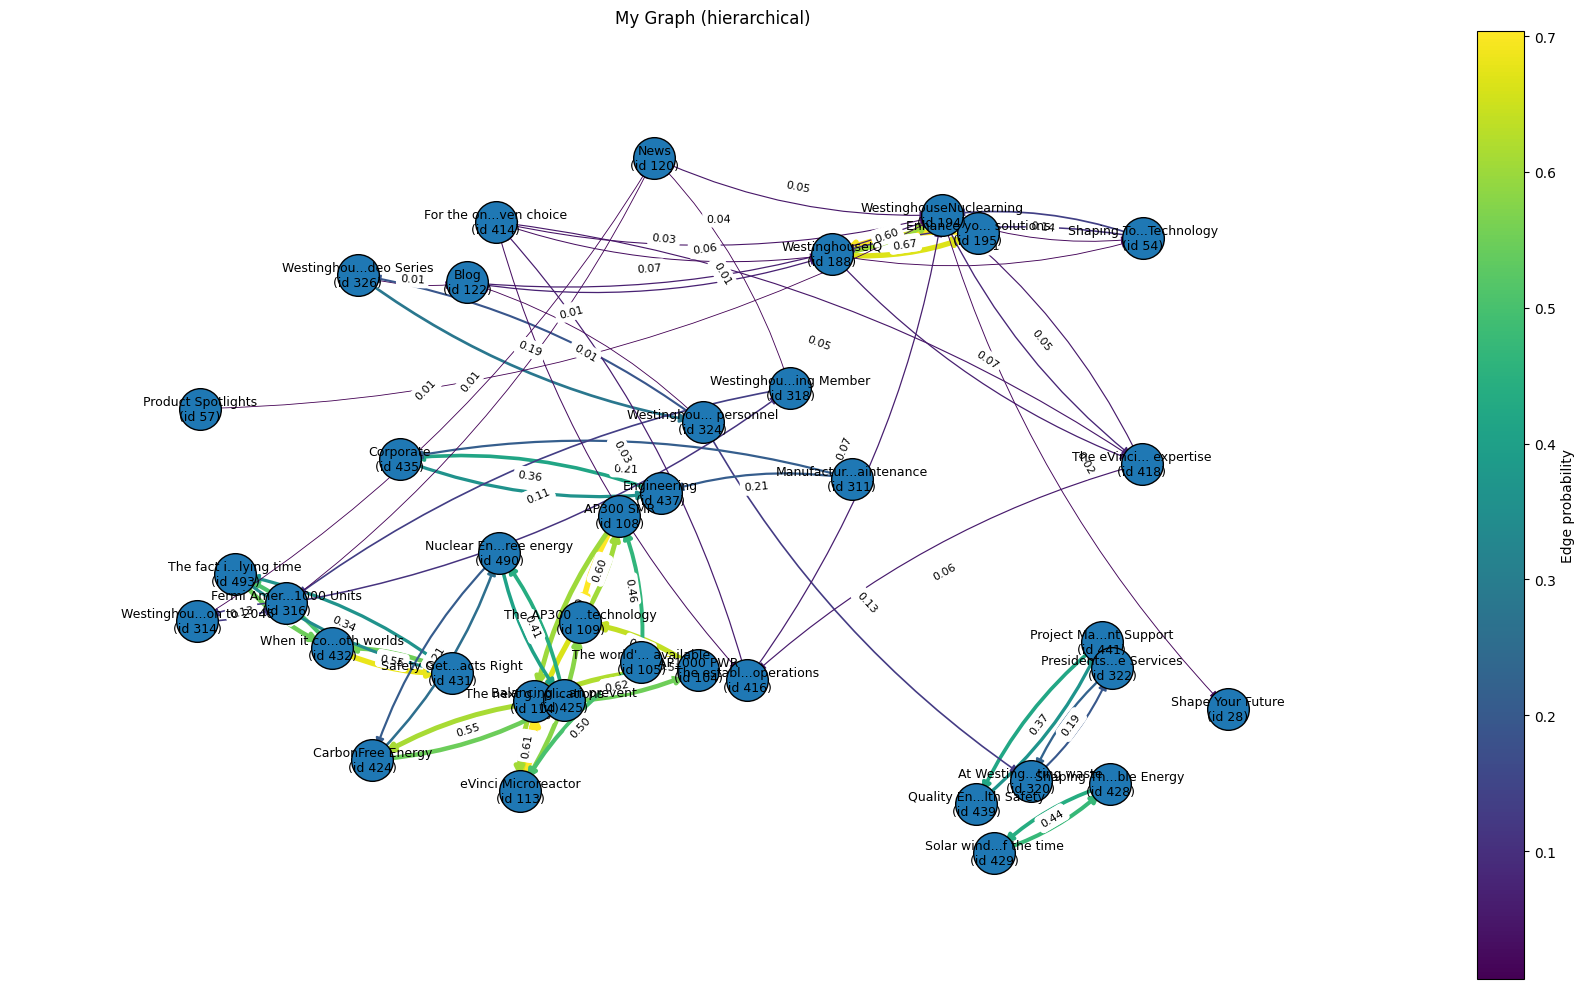

{'G': <networkx.classes.digraph.DiGraph at 0x731cca6a00e0>,
 'pos': {108: array([-0.11403421,  0.0635946 ]),
  109: array([-0.17921892, -0.21198626]),
  113: array([-0.27964473, -0.65281496]),
  114: array([-0.25560923, -0.4185138 ]),
  195: array([0.48336913, 0.80299946]),
  188: array([0.24037525, 0.74749209]),
  104: array([ 0.01773325, -0.33842182]),
  105: array([-0.07754628, -0.3178631 ]),
  432: array([-0.5924829 , -0.28045526]),
  431: array([-0.39249422, -0.34523443]),
  425: array([-0.2064286 , -0.41549164]),
  424: array([-0.52550348, -0.57211696]),
  194: array([0.42350486, 0.85098614]),
  493: array([-0.75432097, -0.08613311]),
  429: array([ 0.51032383, -0.81436166]),
  428: array([ 0.70370024, -0.63565016]),
  490: array([-0.31445916, -0.03221887]),
  441: array([ 0.68957119, -0.26371017]),
  439: array([ 0.48078548, -0.68834294]),
  437: array([-0.04503194,  0.12386839]),
  435: array([-0.48015135,  0.21357559]),
  326: array([-0.5500346 ,  0.69433461]),
  324: array([0

In [ ]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(txts, "presidents kaizen", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)